In [1]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import vmap, jit
import matplotlib.pyplot as plt
import joblib
from qdots_qll.models import game
from qdots_qll import all_funcs
import seaborn as sns
import pandas as pd
import scipy
from functools import reduce

In [2]:
import matplotlib.font_manager as font_manager

# Add every font at the specified location
font_dir = ["/Users/darioradecic/Downloads/Merriweather"]
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)

# font_manager.get_font_names()


from matplotlib import rcParams

rcParams["font.family"] = "Lato"

In [3]:
sns.set_palette("colorblind")

In [4]:
names_true = [
    "$\\gamma ( - \\eta)$",
    "$\\gamma ( + \\eta)$",
    "$S ( - \\eta)$",
    "$S ( +\\eta)$",
]
names_hat = [
    "$\\hat{\\gamma} ( - \\eta)$",
    "$\\hat{\\gamma} ( + \\eta)$",
    "$\\hat{S} ( - \\eta)$",
    "$\\hat{S} ( +\\eta)$",
]

In [5]:
# OPTIMIZED
# run_results = joblib.load("../results/run_2024-01-16_18:42:07_results.job")
# run_model = joblib.load("../results/run_2024-01-16_18:42:07_model.job")

# NON OPTIMIZED

# run_results = joblib.load("../results/run_2024-01-17_11:07:58_results.job")
# run_model = joblib.load("../results/run_2024-01-17_11:07:58_model.job")

# det optimized

run_results = joblib.load("../results/run_2024-01-22_20:29:42_results.job")
run_model = joblib.load("../results/run_2024-01-22_20:29:42_model.job")


true_parameters = game.true_pars

number_of_samples = 500

iters = np.arange(0, 4000)

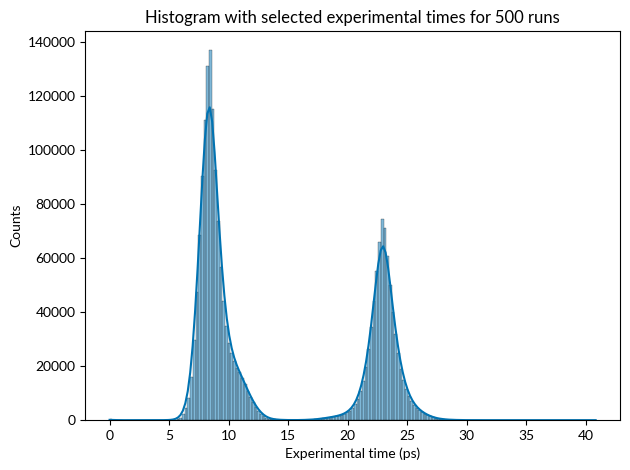

In [6]:
# sns.histplot(np.array(run_results.times_array).flatten(), kde=True)
# plt.title("Histogram with selected experimental times for 500 runs")
# plt.xlabel("Experimental time (ps)")
# plt.ylabel("Counts")
# # plt.yscale('log')
# plt.tight_layout()
# plt.savefig('/tmp/img_code/times_hist_det_optimized.pdf', dpi=600)
# plt.show()


# plt.hist(np.array(run_results.times_array).flatten(), bins=100)
# plt.title("Histogram with selected experimental times for 500 runs")
# plt.xlabel("Experimental time (ps)")
# plt.ylabel("Counts")
# plt.show()

In [32]:
def f_to_replace_with_nan(covariances, iteration):
    arr = np.array(covariances)
    arr[iteration + 1 :] = np.nan
    return arr


def return_cov_mse_per_step(results_run, true_parameters, number_of_samples):
    np_cov_arr = np.array(results_run.cov_array)
    np_estimates_arr = np.array(results_run.estimates_array)
    np_iter = np.array(results_run.iteration)

    for i in range(number_of_samples):
        np_cov_arr[i] = f_to_replace_with_nan(np_cov_arr[i], np_iter[i])
        np_estimates_arr[i] = f_to_replace_with_nan(
            np_estimates_arr[i], np_iter[i]
        )

    all_runs_diff_squared = (true_parameters - np_estimates_arr) ** 2

    mse_array_mean = np.nanmean(
        np.nanmean(all_runs_diff_squared, axis=2), axis=0
    )
    mse_array_median = np.nanmedian(
        np.nanmean(all_runs_diff_squared, axis=2), axis=0
    )

    mse_array_std = np.nanstd(
        np.nanmean(all_runs_diff_squared, axis=2), axis=0
    )

    cov_norm_array = jax.vmap(
        lambda a: vmap(jnp.linalg.norm, (0))(a), in_axes=(0)
    )(np_cov_arr)

    cov_norm_array_mean = np.nanmean(cov_norm_array, axis=0)
    cov_norm_array_median = np.nanmedian(cov_norm_array, axis=0)
    cov_norm_array_std = np.nanstd(cov_norm_array, axis=0)

    return [
        [
            cov_norm_array,
            [cov_norm_array_mean, cov_norm_array_median, cov_norm_array_std],
        ],
        [
            all_runs_diff_squared,
            [mse_array_mean, mse_array_median, mse_array_std],
        ],
    ]

In [33]:
[
    [
        cov_norm_array,
        [cov_norm_array_mean, cov_norm_array_median, cov_norm_array_std],
    ],
    [
        mse_array,
        [mse_array_mean, mse_array_median, mse_array_std],
    ],
] = return_cov_mse_per_step(run_results, true_parameters, number_of_samples)

In [34]:
variances_array = jax.vmap(lambda a: vmap(jnp.diag, (0))(a), in_axes=(0))(
    run_results.cov_array
)

variances_mean = np.nanmean(variances_array, axis=0)
variances_std = np.nanstd(variances_array, axis=0)


mse_indep_mean = np.nanmean(mse_array, axis=0)
mse_indep_std = np.nanstd(mse_array, axis=0)

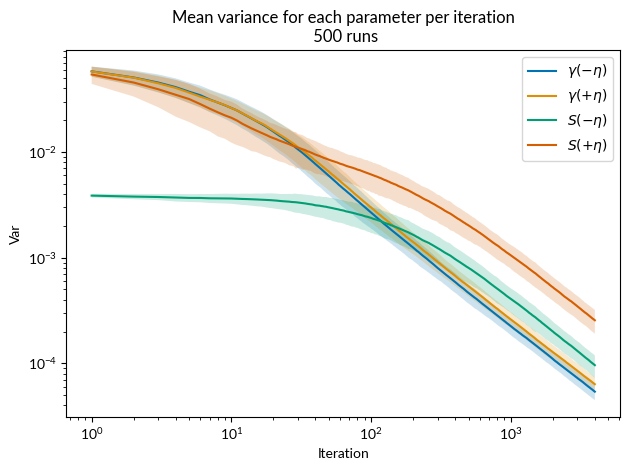

In [35]:
for i in range(4):
    plt.plot(iters[1:], variances_mean[1:, i], label=names_true[i])
    plt.fill_between(
        x=iters[1:],
        y1=variances_mean[1:, i] - variances_std[1:, i],
        y2=variances_mean[1:, i] + variances_std[1:, i],
        alpha=0.2,
    )

plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.title("Mean variance for each parameter per iteration\n 500 runs")
plt.xlabel("Iteration")
plt.ylabel("Var")
plt.tight_layout()
# plt.savefig('/tmp/img_code/mean_var_separated_iteration.pdf', dpi=600)

plt.show()

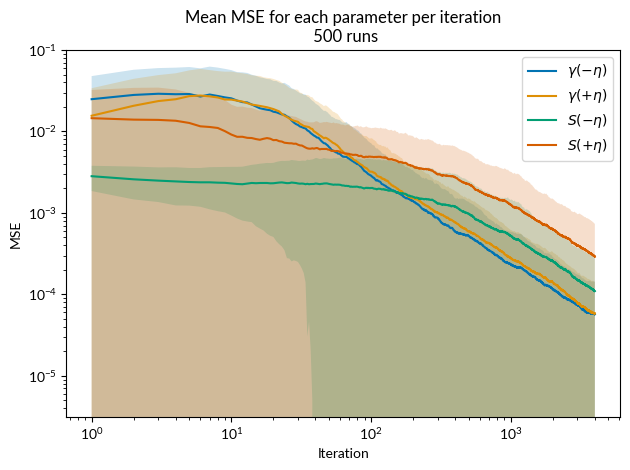

In [36]:
for i in range(4):
    plt.plot(iters[1:], mse_indep_mean[1:, i], label=names_true[i])
    plt.fill_between(
        x=iters[1:],
        y1=mse_indep_mean[1:, i] - mse_indep_std[1:, i],
        y2=mse_indep_mean[1:, i] + mse_indep_std[1:, i],
        alpha=0.2,
    )

plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.title("Mean MSE for each parameter per iteration\n 500 runs")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.tight_layout()
# plt.savefig('/tmp/img_code/mean_mse_separated_iteration.pdf', dpi=600)

plt.show()

In [37]:
aux_df_list = []
for i in range(4):
    aux_df_list.append(
        pd.DataFrame(
            {
                "iteration": iters[1:],
                "Variance": variances_mean[1:, i],
                "MSE": mse_indep_mean[1:, i],
                "Parameter": names_true[i],
            }
        )
    )

aux_df_concat = pd.concat(aux_df_list)
dfm = aux_df_concat.melt(
    ["iteration", "Parameter"], var_name="Cols", value_name="vals"
)

In [38]:
cumulative_times_per_run = (
    vmap(jnp.cumsum, in_axes=(0))(run_results.times_array) * 10
)[:, 1:]

aux_list = []
for i in range(500):
    for j in range(4):
        aux_list.append(
            pd.DataFrame(
                {
                    "Time": cumulative_times_per_run[i],
                    "Variance": variances_array[i, 1:, j],
                    "MSE": mse_array[i, 1:, j],
                    "Parameter": names_true[j],
                    "Run": i,
                }
            )
        )

cumtimes_df_concat = pd.concat(aux_list)

concat_df = pd.concat(aux_list, join="inner").sort_values(by="Time")
concat_df["Time"] = pd.to_timedelta(concat_df.Time, unit="ns")

In [39]:
mean_df = (
    concat_df.groupby(
        [concat_df.Time.dt.floor("1000ns"), concat_df.Parameter, concat_df.Run]
    )
    .agg({"Variance": ["mean", "std"], "MSE": ["mean", "std"]})
    .reset_index()
    .drop(columns="MSE")
)

dfm = mean_df.melt(
    [
        "Time",
        "Parameter",
    ],
    var_name="Cols",
    value_name="vals",
)

dfm = dfm[
    (dfm.Time.dt.total_seconds() <= 7 * 1e5 / (1e9))
    & (dfm.Time.dt.total_seconds() > 0 / (1e9))
]

aggregated_time_dfm = (
    dfm[(dfm.Parameter == names_true[0]) & (dfm.Cols == "Variance")]
    .Time.to_numpy()
    .astype("float")
)

/tmp/ipykernel_247357/1493370689.py:7: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  .drop(columns="MSE")


In [29]:
# mean_df_optimized = mean_df
# mean_df_optimized["Method"] = "Optimized"

# dfm_optimized = dfm
# dfm_optimized["Method"] = "Optimized"

In [40]:
# mean_df_unoptimized = mean_df
# mean_df_unoptimized["Method"] = "Non Optimized"

# dfm_unoptimized = dfm
# dfm_unoptimized["Method"] = "Non optimized"

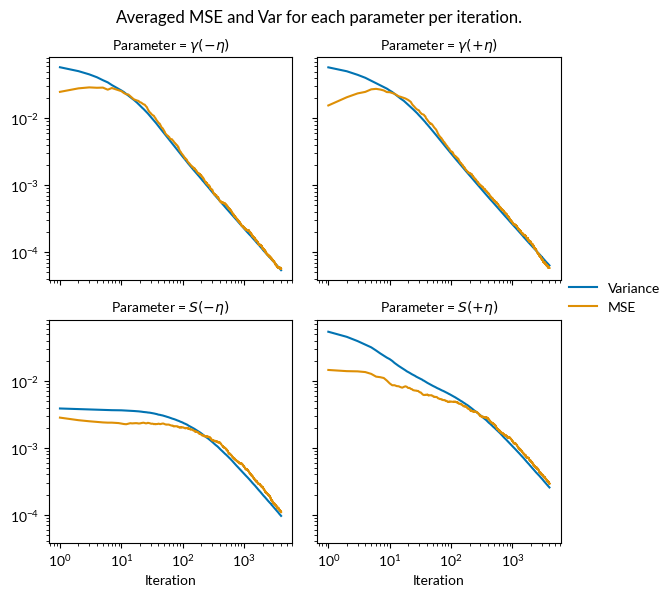

In [31]:
sns.set_palette("colorblind")

g = sns.FacetGrid(data=dfm, col="Parameter", col_wrap=2)
g.map_dataframe(
    sns.lineplot, x="iteration", y="vals", hue="Cols", estimator=None
)

g.add_legend()

plt.yscale("log")
plt.xscale("log")
g.set_axis_labels("Iteration", y_var="")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Averaged MSE and Var for each parameter per iteration.")
# plt.tight_layout()
sns.despine(right=False, top=False)
# plt.savefig("/tmp/img_code/.pdf", dpi=600)
# plt.savefig('/tmp/img_code/joint_mse_var_separated_iteration.pdf', dpi=600)

plt.show()

In [32]:
cumulative_times_per_run = (
    vmap(jnp.cumsum, in_axes=(0))(run_results.times_array) * 10
)[:, 1:]

# all_time_df = [
#     (
#         lambda a, b, c: pd.DataFrame(
#             {
#                 "time": a,
#                 "cov_norm": b,
#                 "mse": c,
#             }
#         ).iloc[1:]
#     )(a, b, c)
#     for (a, b, c) in zip(cumulative_times_per_run, cov_norm_array, mse_array)
# ]

In [33]:
aux_list = []
for i in range(500):
    for j in range(4):
        aux_list.append(
            pd.DataFrame(
                {
                    "Time": cumulative_times_per_run[i],
                    "Variance": variances_array[i, 1:, j],
                    "MSE": mse_array[i, 1:, j],
                    "Parameter": names_true[j],
                    "Run": i,
                }
            )
        )

cumtimes_df_concat = pd.concat(aux_list)

concat_df = pd.concat(aux_list, join="inner").sort_values(by="Time")
concat_df["Time"] = pd.to_timedelta(concat_df.Time, unit="ns")

In [34]:
concat_df

,Time,Variance,MSE,Parameter,Run
0,0 days 00:00:00.000000092,0.053885,0.000079,$\gamma ( - \eta)$,449
0,0 days 00:00:00.000000092,0.065118,0.001258,$\gamma ( + \eta)$,449
0,0 days 00:00:00.000000092,0.003619,0.001337,$S ( - \eta)$,449
0,0 days 00:00:00.000000092,0.032799,0.007731,$S ( +\eta)$,449
0,0 days 00:00:00.000000094,0.066657,0.028327,$S ( +\eta)$,439
...,...,...,...,...,...
3998,0 days 00:00:00.001025163,0.000037,0.000041,$\gamma ( - \eta)$,364
3998,0 days 00:00:00.001025241,0.000110,0.000607,$S ( - \eta)$,240
3998,0 days 00:00:00.001025241,0.000042,0.000422,$\gamma ( - \eta)$,240
3998,0 days 00:00:00.001025241,0.000049,0.000050,$\gamma ( + \eta)$,240


In [35]:
mean_df = (
    concat_df.groupby(
        [
            concat_df.Time.dt.floor("1000ns"),
            concat_df.Parameter,
            concat_df.Run,
        ],
    )
    .agg({"Variance": ["mean"], "MSE": ["mean"]})
    .reset_index()
    .drop(columns="MSE")
)

mean_df = mean_df[
    (mean_df.Time.dt.total_seconds() <= 7 * 1e5 / (1e9))
    & (mean_df.Time.dt.total_seconds() > 0 / (1e9))
]

mean_df.columns

/tmp/ipykernel_245957/603293150.py:12: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  .drop(columns="MSE")


MultiIndex([(     'Time',     ''),
            ('Parameter',     ''),
            (      'Run',     ''),
            ( 'Variance', 'mean')],
           )

In [ ]:
mean_df

In [42]:
dfm_both = pd.concat([dfm_optimized, dfm_unoptimized])
dfm_both = dfm_both[(dfm_both.Cols == "Variance")]

In [44]:
mean_df_both = pd.concat([mean_df_optimized, mean_df_unoptimized])
# dfm_both = dfm_both[(dfm_both.Cols == "Variance")]

In [55]:
# dfm_both = dfm_both[(dfm_both.Cols == "Variance")]

NameError: name 'dfm_both' is not defined

In [50]:
mean_df_both = mean_df_both[
    (mean_df_both.Time.dt.total_seconds() <= 5 * 1e5 / (1e9))
    & (mean_df_both.Time.dt.total_seconds() > 0 / (1e9))
]

In [53]:
mean_df_both["Method"].unique()

array(['Optimized', 'Non Optimized'], dtype=object)

In [56]:
mean_df_both["Method"] = mean_df_both["Method"].astype("category")

mean_df_both["Method"] = mean_df_both["Method"].cat.rename_categories(
    {"Optimized": "Det optimization", "Non Optimized": "Norm optimization"}
)

In [57]:
def aux_plot(*args, **kwargs):
    x = aggregated_time_dfm
    y1 = (lambda a: 500 / a)((aggregated_time_dfm))
    y2 = (lambda a: 10000 / a**2)((aggregated_time_dfm))

    plt.plot(
        x,
        y1,
        "-.",
        label="SQL $ \\propto 1/ t$",
        alpha=0.7,
    )
    plt.plot(
        x,
        y2,
        "-.",
        label="Heisenberg limit $ \\propto 1/ t^2$",
        alpha=0.7,
    )

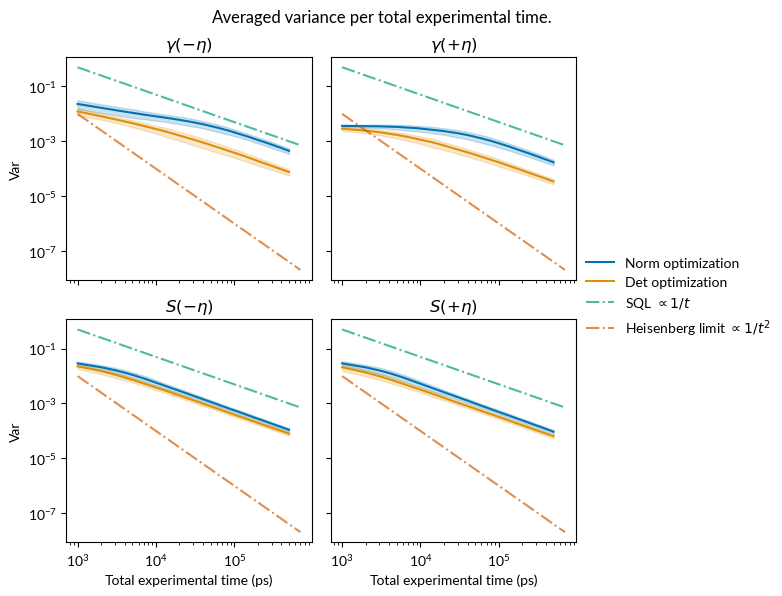

In [60]:
sns.set_palette("colorblind")

g = sns.FacetGrid(
    data=mean_df_both,
    col=("Parameter", ""),
    col_wrap=2,
)

g.map_dataframe(
    sns.lineplot,
    x=("Time", ""),
    y=("Variance", "mean"),
    errorbar="sd",
    hue="Method",
)

g.map_dataframe(aux_plot)

axes = g.axes.flatten()
for i in range(4):
    axes[i].set_title(names_true[i])
    axes[i].set_ylabel("Var")

g.set_axis_labels("Total experimental time (ps)", y_var="Var")

# axes[0].set_title("Internal")
# axes[1].set_title("External")

plt.xscale("log")
plt.yscale("log")

g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Averaged variance per total experimental time.")
# plt.tight_layout()
sns.despine(right=False, top=False)
# plt.savefig("/tmp/img_code/.pdf", dpi=600)

g.add_legend()
plt.savefig("/tmp/img_code/comparing_var_norm_det_iteration.pdf", dpi=600)
plt.show()

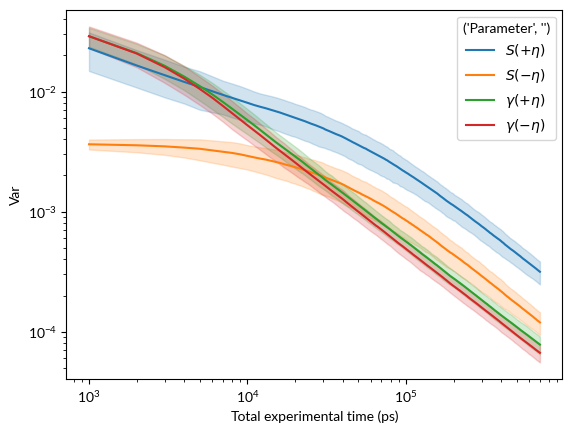

In [138]:
sns.lineplot(
    data=mean_df,
    x=("Time", ""),
    y=("Variance", "mean"),
    hue=("Parameter", ""),
    errorbar="sd",
)
plt.xlabel("Total experimental time (ps)")
plt.ylabel("Var")
plt.xscale("log")
plt.yscale("log")

In [43]:
concat_df

,Time,Variance,MSE,Parameter,Run
0,0 days 00:00:00.000000092,0.053885,0.000079,$\gamma ( - \eta)$,449
0,0 days 00:00:00.000000092,0.065118,0.001258,$\gamma ( + \eta)$,449
0,0 days 00:00:00.000000092,0.003619,0.001337,$S ( - \eta)$,449
0,0 days 00:00:00.000000092,0.032799,0.007731,$S ( +\eta)$,449
0,0 days 00:00:00.000000094,0.066657,0.028327,$S ( +\eta)$,439
...,...,...,...,...,...
3998,0 days 00:00:00.001025163,0.000037,0.000041,$\gamma ( - \eta)$,364
3998,0 days 00:00:00.001025241,0.000110,0.000607,$S ( - \eta)$,240
3998,0 days 00:00:00.001025241,0.000042,0.000422,$\gamma ( - \eta)$,240
3998,0 days 00:00:00.001025241,0.000049,0.000050,$\gamma ( + \eta)$,240


In [47]:
mean_df

,Time,Parameter,Run,Variance,Method
,,,,mean,
2000,0 days 00:00:00.000001,$S ( +\eta)$,0,0.022368,Non Optimized
2001,0 days 00:00:00.000001,$S ( +\eta)$,1,0.025576,Non Optimized
2002,0 days 00:00:00.000001,$S ( +\eta)$,2,0.017505,Non Optimized
2003,0 days 00:00:00.000001,$S ( +\eta)$,3,0.018964,Non Optimized
2004,0 days 00:00:00.000001,$S ( +\eta)$,4,0.011795,Non Optimized
...,...,...,...,...,...
1401995,0 days 00:00:00.000700,$\gamma ( - \eta)$,495,0.000073,Non Optimized
1401996,0 days 00:00:00.000700,$\gamma ( - \eta)$,496,0.000065,Non Optimized
1401997,0 days 00:00:00.000700,$\gamma ( - \eta)$,497,0.000078,Non Optimized


In [30]:
concat_df

NameError: name 'concat_df' is not defined

In [48]:
concat_df.groupby(
    [concat_df.Time.dt.floor("1000ns"), concat_df.Parameter, concat_df]
)

ValueError: Grouper for '<class 'pandas.core.frame.DataFrame'>' not 1-dimensional

In [42]:
# mean_df = concat_df.groupby([concat_df.Time.dt.floor("1000ns"), concat_df.Parameter]).mean()

mean_df = (
    concat_df.groupby(
        [concat_df.Time.dt.floor("1000ns"), concat_df.Parameter, concat_df]
    )
    .agg({"Variance": ["mean", "std"], "MSE": ["mean", "std"]})
    .reset_index()
    .drop(columns="MSE")
)

dfm = mean_df.melt(
    [
        "Time",
        "Parameter",
    ],
    var_name="Cols",
    value_name="vals",
)

dfm = dfm[
    (dfm.Time.dt.total_seconds() <= 7 * 1e5 / (1e9))
    & (dfm.Time.dt.total_seconds() > 0 / (1e9))
]

aggregated_time_dfm = (
    dfm[(dfm.Parameter == names_true[0]) & (dfm.Cols == "Variance")]
    .Time.to_numpy()
    .astype("float")
)

ValueError: Grouper for '<class 'pandas.core.frame.DataFrame'>' not 1-dimensional

In [94]:
mean_df["Variance", "mean"]

0       0.040966
1       0.003759
2       0.045707
3       0.046373
4       0.023611
          ...   
4099    0.000039
4100    0.000291
4101    0.000116
4102    0.000061
4103    0.000040
Name: (Variance, mean), Length: 4104, dtype: float32

In [101]:
dfm.head()

,Time,Parameter,Cols,vals
4,0 days 00:00:00.000001,$S ( +\eta)$,Variance,0.023611
5,0 days 00:00:00.000001,$S ( - \eta)$,Variance,0.003647
6,0 days 00:00:00.000001,$\gamma ( + \eta)$,Variance,0.029301
7,0 days 00:00:00.000001,$\gamma ( - \eta)$,Variance,0.029448
8,0 days 00:00:00.000002,$S ( +\eta)$,Variance,0.016874


In [87]:
mean_df.head()

Time           Parameter  Variance          
                                                  mean       std
0        0 days 00:00:00        $S ( +\eta)$  0.040966  0.014370
1        0 days 00:00:00       $S ( - \eta)$  0.003759  0.000258
2        0 days 00:00:00  $\gamma ( + \eta)$  0.045707  0.010533
3        0 days 00:00:00  $\gamma ( - \eta)$  0.046373  0.010636
4 0 days 00:00:00.000001        $S ( +\eta)$  0.023611  0.009543

In [99]:
mean_df.melt(["Time", "Parameter", "Variance"], var_name=["", "statistic"])

AttributeError: 'DataFrame' object has no attribute 'dtype'

In [100]:
mean_df

Time           Parameter  Variance          
                                                     mean       std
0           0 days 00:00:00        $S ( +\eta)$  0.040966  0.014370
1           0 days 00:00:00       $S ( - \eta)$  0.003759  0.000258
2           0 days 00:00:00  $\gamma ( + \eta)$  0.045707  0.010533
3           0 days 00:00:00  $\gamma ( - \eta)$  0.046373  0.010636
4    0 days 00:00:00.000001        $S ( +\eta)$  0.023611  0.009543
...                     ...                 ...       ...       ...
4099 0 days 00:00:00.001024  $\gamma ( - \eta)$  0.000039  0.000003
4100 0 days 00:00:00.001025        $S ( +\eta)$  0.000291  0.000050
4101 0 days 00:00:00.001025       $S ( - \eta)$  0.000116  0.000010
4102 0 days 00:00:00.001025  $\gamma ( + \eta)$  0.000061  0.000020
4103 0 days 00:00:00.001025  $\gamma ( - \eta)$  0.000040  0.000003

[4104 rows x 4 columns]

In [75]:
mean_df.drop(columns="MSE")

/tmp/ipykernel_241283/3664043280.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  mean_df.drop(columns="MSE")


Time           Parameter  Variance          
                                                     mean       std
0           0 days 00:00:00        $S ( +\eta)$  0.040966  0.014370
1           0 days 00:00:00       $S ( - \eta)$  0.003759  0.000258
2           0 days 00:00:00  $\gamma ( + \eta)$  0.045707  0.010533
3           0 days 00:00:00  $\gamma ( - \eta)$  0.046373  0.010636
4    0 days 00:00:00.000001        $S ( +\eta)$  0.023611  0.009543
...                     ...                 ...       ...       ...
4099 0 days 00:00:00.001024  $\gamma ( - \eta)$  0.000039  0.000003
4100 0 days 00:00:00.001025        $S ( +\eta)$  0.000291  0.000050
4101 0 days 00:00:00.001025       $S ( - \eta)$  0.000116  0.000010
4102 0 days 00:00:00.001025  $\gamma ( + \eta)$  0.000061  0.000020
4103 0 days 00:00:00.001025  $\gamma ( - \eta)$  0.000040  0.000003

[4104 rows x 4 columns]

In [177]:
concat_df

,Time,Variance,MSE,Parameter,Run
0,0 days 00:00:00.000000001,0.065249,0.017393,$\gamma ( - \eta)$,66
0,0 days 00:00:00.000000001,0.003870,0.003383,$S ( - \eta)$,66
0,0 days 00:00:00.000000001,0.067324,0.012636,$S ( +\eta)$,66
0,0 days 00:00:00.000000001,0.067438,0.007366,$\gamma ( + \eta)$,66
0,0 days 00:00:00.000000002,0.064589,0.014906,$S ( +\eta)$,424
...,...,...,...,...,...
3997,0 days 00:00:00.000824413,0.000052,0.000097,$\gamma ( + \eta)$,266
3998,0 days 00:00:00.000824701,0.000055,0.000317,$\gamma ( - \eta)$,266
3998,0 days 00:00:00.000824701,0.000052,0.000098,$\gamma ( + \eta)$,266
3998,0 days 00:00:00.000824701,0.000067,0.000047,$S ( - \eta)$,266


KeyboardInterrupt: 

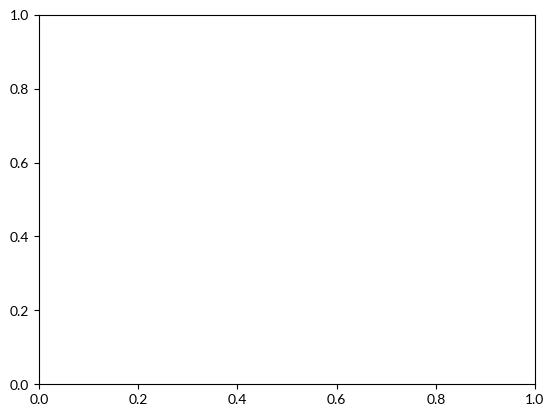

In [70]:
sns.lineplot(concat_df, x="Time", y="Variance", style="Parameter")

In [22]:
# dfm_unoptimized = dfm
# dfm_optimized = dfm

# dfm_optimized["Method"] = "Optimized"
# dfm_unoptimized["Method"] = "Non optimized"

In [24]:
dfm_both = pd.concat([dfm_optimized, dfm_unoptimized])
dfm_both = dfm_both[(dfm_both.Cols == "Variance")]

In [25]:
dfm_both

,iteration,Parameter,Cols,vals,Method
0,1,$\gamma ( - \eta)$,Variance,0.058362,Optimized
1,2,$\gamma ( - \eta)$,Variance,0.051270,Optimized
2,3,$\gamma ( - \eta)$,Variance,0.045314,Optimized
3,4,$\gamma ( - \eta)$,Variance,0.040867,Optimized
4,5,$\gamma ( - \eta)$,Variance,0.037112,Optimized
...,...,...,...,...,...
15991,3995,$S ( +\eta)$,Variance,0.000256,Non optimized
15992,3996,$S ( +\eta)$,Variance,0.000256,Non optimized
15993,3997,$S ( +\eta)$,Variance,0.000256,Non optimized
15994,3998,$S ( +\eta)$,Variance,0.000255,Non optimized


In [27]:
dfm

,iteration,Parameter,Cols,vals,Method
0,1,$\gamma ( - \eta)$,Variance,0.058123,Non optimized
1,2,$\gamma ( - \eta)$,Variance,0.050831,Non optimized
2,3,$\gamma ( - \eta)$,Variance,0.045500,Non optimized
3,4,$\gamma ( - \eta)$,Variance,0.041194,Non optimized
4,5,$\gamma ( - \eta)$,Variance,0.037242,Non optimized
...,...,...,...,...,...
31987,3995,$S ( +\eta)$,MSE,0.000292,Non optimized
31988,3996,$S ( +\eta)$,MSE,0.000292,Non optimized
31989,3997,$S ( +\eta)$,MSE,0.000292,Non optimized
31990,3998,$S ( +\eta)$,MSE,0.000292,Non optimized


In [29]:
dfm

,iteration,Parameter,Cols,vals,Method
0,1,$\gamma ( - \eta)$,Variance,0.058123,Non optimized
1,2,$\gamma ( - \eta)$,Variance,0.050831,Non optimized
2,3,$\gamma ( - \eta)$,Variance,0.045500,Non optimized
3,4,$\gamma ( - \eta)$,Variance,0.041194,Non optimized
4,5,$\gamma ( - \eta)$,Variance,0.037242,Non optimized
...,...,...,...,...,...
31987,3995,$S ( +\eta)$,MSE,0.000292,Non optimized
31988,3996,$S ( +\eta)$,MSE,0.000292,Non optimized
31989,3997,$S ( +\eta)$,MSE,0.000292,Non optimized
31990,3998,$S ( +\eta)$,MSE,0.000292,Non optimized


In [28]:
aggregated_time_dfm = (
    dfm[(dfm.Parameter == names_true[0]) & (dfm.Cols == "Variance")]
    .Time.to_numpy()
    .astype("float")
)

AttributeError: 'DataFrame' object has no attribute 'Time'

In [42]:
def aux_plot(*args, **kwargs):
    x = aggregated_time_dfm
    y1 = (lambda a: 500 / a)((aggregated_time_dfm))
    y2 = (lambda a: 10000 / a**2)((aggregated_time_dfm))

    plt.plot(
        x,
        y1,
        "-.",
        label="SQL $ \\propto 1/ t$",
        alpha=0.7,
    )
    plt.plot(
        x,
        y2,
        "-.",
        label="Heisenberg limit $ \\propto 1/ t^2$",
        alpha=0.7,
    )

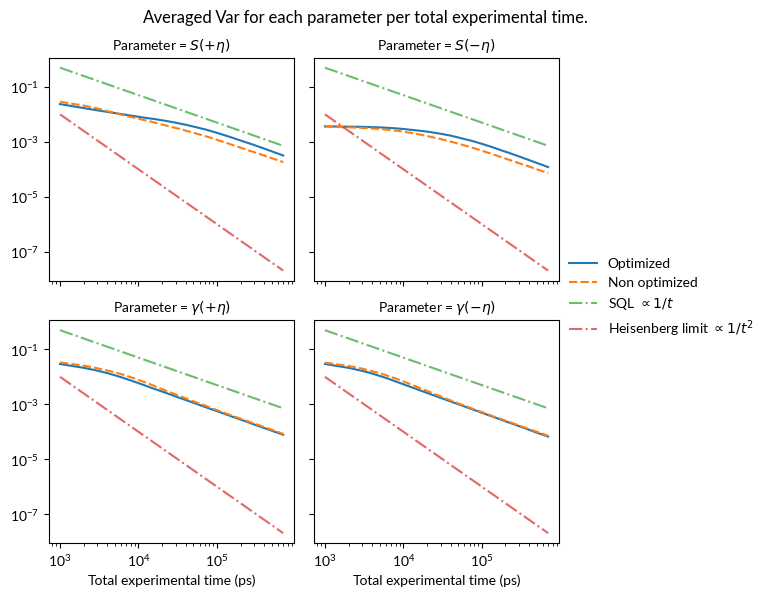

In [43]:
g = sns.FacetGrid(
    data=dfm_both,
    col="Parameter",
    col_wrap=2,
)
g.map_dataframe(
    sns.lineplot,
    x="Time",
    y="vals",
    hue="Method",
    style="Method",
    estimator=None,
)

g.map_dataframe(aux_plot)
g.add_legend()


# g.axes[0, 0].plot()

g.set_axis_labels("Total experimental time (ps)", y_var="")
plt.yscale("log")
plt.xscale("log")
# g.fig.suptitle("Scaling of MSE and Variance for each parameter")
sns.despine(right=False, top=False)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Averaged Var for each parameter per total experimental time.")
plt.savefig(
    "/tmp/img_code/comparing_optimized_unoptimized_variance.pdf", dpi=600
)

plt.show()

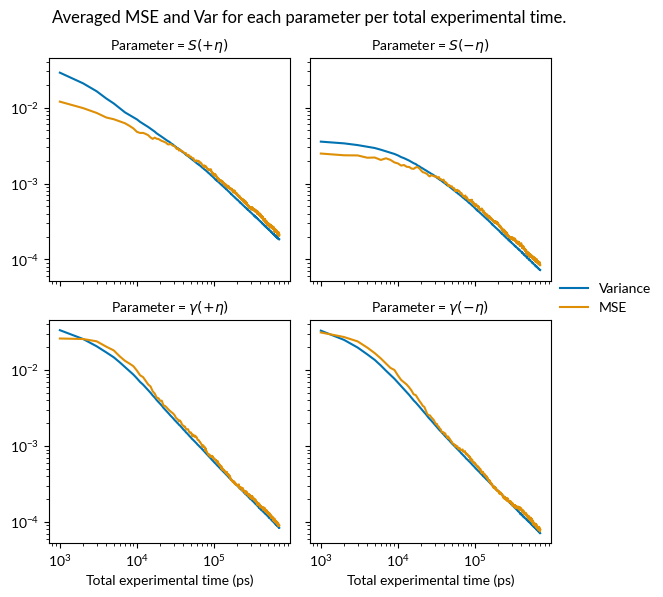

In [218]:
g = sns.FacetGrid(
    data=dfm,
    col="Parameter",
    col_wrap=2,
)
g.map_dataframe(sns.lineplot, x="Time", y="vals", hue="Cols", estimator=None)

# g.map_dataframe(aux_plot)
g.add_legend()


# g.axes[0, 0].plot()

g.set_axis_labels("Total experimental time (ps)", y_var="")
plt.yscale("log")
plt.xscale("log")
# g.fig.suptitle("Scaling of MSE and Variance for each parameter")
sns.despine(right=False, top=False)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle(
    "Averaged MSE and Var for each parameter per total experimental time."
)
plt.savefig("/tmp/img_code/joint_mse_var_separated_exptime.pdf", dpi=600)

plt.show()

In [219]:
final_cov_matrix = jax.vmap((lambda a, b: a[b]), in_axes=(0, 0))(
    run_results.cov_array, run_results.iteration
)

final_cov_norm = jax.vmap(jnp.linalg.norm, in_axes=(0))(final_cov_matrix)

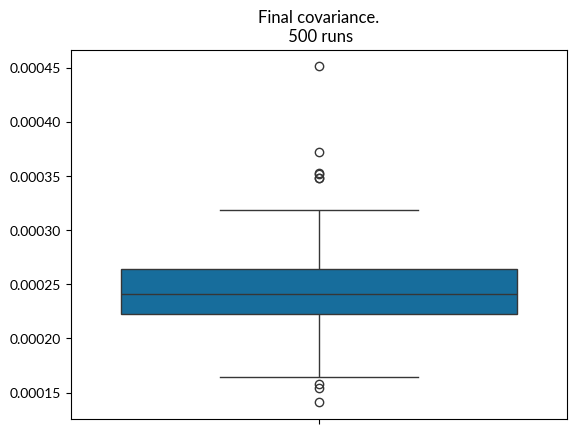

In [220]:
sns.boxplot(y=final_cov_norm)
# plt.yscale("log")
plt.title("Final covariance.\n 500 runs")
plt.savefig("/tmp/img_code/hist_final_cov_norm.pdf", dpi=600)

plt.show()

In [221]:
final_estimates = jax.vmap((lambda a, b: a[b]), in_axes=(0, 0))(
    run_results.estimates_array, run_results.iteration
)

df = pd.DataFrame(final_estimates, columns=names_true)

df_true_pars = pd.DataFrame(true_parameters[np.newaxis, :], columns=names_true)

/home/antonio/miniconda3/envs/jax/lib/python3.11/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


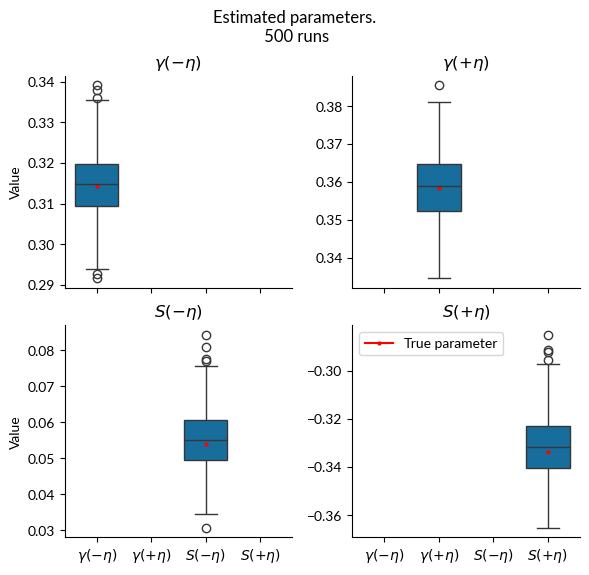

In [222]:
g = sns.FacetGrid(pd.melt(df), col="variable", col_wrap=2, sharey=False)

g.map(sns.boxplot, "variable", "value")


i = 0
for ax, punto in zip(g.axes.flat, list(true_parameters)):
    ax.plot(
        i, punto, color="red", marker="o", markersize=2, label="True parameter"
    )  # Ajustar 0 según la posición del boxplot
    ax.set_title(names_true[i])
    # ax.set_title("")
    ax.set_xlabel("")
    i = i + 1
    # ax.legend()
# g.set(ylim=(0, 6))

g.set_axis_labels(names_true, "Value")
for ax in g.axes.flat:
    ax.set(xlabel="")

# g.add_legend()
plt.legend()
g.fig.subplots_adjust(top=0.87)
g.fig.suptitle("Estimated parameters.\n 500 runs")
plt.savefig("/tmp/img_code/boxplot_est_parameters.pdf", dpi=600)


plt.show()

In [223]:
from scipy.stats import bootstrap

mean = np.array(final_estimates.mean(axis=0))
standard_error_mean = np.array(final_estimates).std(axis=0) / np.sqrt(
    number_of_samples
)

median = np.median(final_estimates, axis=0)


confidence_interval_mean = bootstrap(
    (final_estimates,),
    np.mean,
    confidence_level=0.95,
    random_state=1,
    method="percentile",
    axis=0,
)
bootstrap_ci = bootstrap(
    (final_estimates,),
    np.median,
    confidence_level=0.95,
    random_state=1,
    method="percentile",
    axis=0,
)
standard_error_median = (
    bootstrap_ci.confidence_interval[1] - bootstrap_ci.confidence_interval[0]
) / 3.92

In [224]:
for i in range(4):
    # print(f"Parameter {str(i)}:  ")
    print(f"Parameter {names_true[i]}:  ")

    print(f"True value: {true_parameters[i]} ")
    print("\n")
    print(f"Mean estimate: {mean[i]:.5f} pm {standard_error_mean[i]:.5f}")
    print(
        f"Median estimate: {median[i]:.5f} pm {standard_error_median[i]:.5f}"
    )
    print("---")
    print(
        f"0.95 Confidence Interval for mean: {confidence_interval_mean.confidence_interval[0][ i]:.5f}, {confidence_interval_mean.confidence_interval[1][  i]:.5f} "
    )
    print(
        f"0.95 Confidence Interval for median: {bootstrap_ci.confidence_interval[0][ i]:.5f}, {bootstrap_ci.confidence_interval[1][  i]:.5f} "
    )
    print("\n")

Parameter $\gamma ( - \eta)$:  
True value: 0.3142159879207611 


Mean estimate: 0.31468 pm 0.00036
Median estimate: 0.31492 pm 0.00045
---
0.95 Confidence Interval for mean: 0.31396, 0.31538 
0.95 Confidence Interval for median: 0.31399, 0.31576 


Parameter $\gamma ( + \eta)$:  
True value: 0.35833001136779785 


Mean estimate: 0.35852 pm 0.00039
Median estimate: 0.35881 pm 0.00055
---
0.95 Confidence Interval for mean: 0.35775, 0.35929 
0.95 Confidence Interval for median: 0.35779, 0.35995 


Parameter $S ( - \eta)$:  
True value: 0.05385100096464157 


Mean estimate: 0.05543 pm 0.00038
Median estimate: 0.05501 pm 0.00041
---
0.95 Confidence Interval for mean: 0.05469, 0.05618 
0.95 Confidence Interval for median: 0.05439, 0.05602 


Parameter $S ( +\eta)$:  
True value: -0.3336949944496155 


Mean estimate: -0.33150 pm 0.00060
Median estimate: -0.33158 pm 0.00075
---
0.95 Confidence Interval for mean: -0.33268, -0.33033 
0.95 Confidence Interval for median: -0.33316, -0.33023 




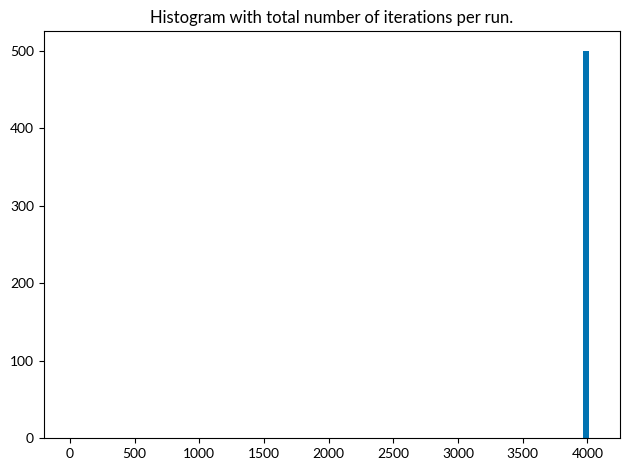

In [225]:
plt.hist(np.array(run_results.iteration).flatten(), bins=100, range=(0, 4050))
plt.title("Histogram with total number of iterations per run.")
plt.tight_layout()
plt.savefig("/tmp/img_code/hist_number_iterations.pdf", dpi=600)

plt.show()
# plt.xlim(0, 5002)
# plt.xscale('log')

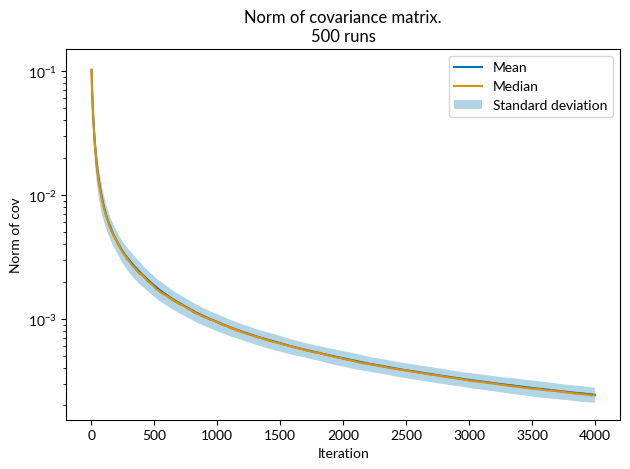

In [226]:
plt.plot(iters[1:], cov_norm_array_mean[1:], label="Mean")
plt.plot(iters[1:], cov_norm_array_median[1:], label="Median")
plt.fill_between(
    x=iters,
    y1=cov_norm_array_mean - cov_norm_array_std,
    y2=cov_norm_array_mean + cov_norm_array_std,
    alpha=0.3,
    label="Standard deviation",
)


# plt.plot(
#     iters[1:],
#     fun_to_fit(iters[1:], *fitting_estimates_cov),
#     label=f"Fitting {fitting_estimates_cov[0]:.4f}x^{fitting_estimates_cov[1]:.4f}",
# )


plt.yscale("log")
# plt.xscale("log")
plt.legend()
plt.title("Norm of covariance matrix.\n500 runs")
plt.xlabel("Iteration")
plt.ylabel("Norm of cov")
plt.tight_layout()

plt.savefig("/tmp/img_code/norm_cov_iteration.pdf", dpi=600)


plt.show()